In [30]:
LLM_score_thresh = 0.01 # only drop the ones LLM does not assign a name 
adj_pval_thresh = 0.05
JI_thresh = 0.1
coverage_thresh = 0.2

## g:profiler enrichment analysis evaluation 

1. updated the gene name, use default gene list. 

    1.1 default setting coverage at 0.2 for both LLM and enrichment 
    
    1.2 remove the coverage requirment for both
    
    1.3 semantic similarity for LLM JI (in separate notebook)


### Common function

In [31]:
import pandas as pd
import numpy as np
#  functions to compute the Jaccard Index and coverage for the query gene list and the GO term genes
def get_JI(query_size: int, term_size: int, intersection_size: int) -> float:
    # Calculate JI
    JI = intersection_size / (query_size + term_size - intersection_size) if query_size + term_size - intersection_size != 0 else 0
    
    return JI

def get_coverage(query_size: int, intersection_size: int) -> float:
    # Calculate the coverage
    coverage = intersection_size / query_size if query_size != 0 else 0
    
    return coverage

def create_success_contingency_table(df):
    # Make the LLM vs enrichr contingency table
    contingency_table = pd.crosstab(df['gprofiler_success_TF'], df['LLM_success_TF'], rownames=['gprofiler_success_TF'], colnames=['LLM_success_TF'])

    # Reorder the rows and columns
    contingency_table = contingency_table.reindex(index=[True, False], columns=[True, False])

    # Add the total column and row
    contingency_table['Total'] = contingency_table.sum(axis=1)
    contingency_table.loc['Total'] = contingency_table.sum(axis=0)

    return contingency_table

def select_rows_and_columns(df, number_of_rows=None):
    # Specify the ordered list of column names you want to return
    ordered_column_names = [
        'n_Genes', 'GeneList', 'LLM Name', 'Score', 'Term', 'GO ID',
        'Adjusted P-value', 'intersection_size', 'term_size', 'intersections',  'gprofiler_coverage', 'LLM_coverage','gprofiler_JI', 
        'LLM_success_TF', 'gprofiler_success_TF'
    ]
    
    # If number_of_rows is not specified, select all rows
    if number_of_rows is None:
        result_df = df.loc[:, ordered_column_names]
    else:
        result_df = df.loc[:, ordered_column_names].head(number_of_rows)
    
    return result_df


def cal_JI_coverage(df) -> pd.DataFrame:
# Apply the get_JI and get_coverage functions to each row and add new columns to the DataFrame
    df['gprofiler_JI'] = df.apply(lambda row: get_JI(row['query_size'], row['term_size'], row['intersection_size']), axis=1)


    df['gprofiler_coverage'] = df.apply(lambda row: get_coverage(row['query_size'], row['intersection_size']), axis=1)
    return df


def coverage_thresholding(df, col, coverage_thresh_list = np.arange(0.0, 1.1, 0.1), term_type = 'enrich_terms', enrichr_adj_pval_thresh = 0.05, LLM_score_thresh = 0.82) -> pd.DataFrame:
    '''
    df: DataFrame with LLM terms, LLM confidence, enriched terms, coverages and adjusted p-values
    col: Column name for the 'coverage' value to be thresholded
    coverage_thresh_list: List of coverage thresholds to evaluate (default: np.arange(0.0, 1.1, 0.1))
    term_type: Type of terms to evaluate ('enrich_terms' or 'LLM_terms')
    enrichr_adj_pval_thresh: Adjusted p-value threshold for enriched terms (default: 0.05)
    LLM_score_thresh: Confidence score threshold for LLM terms (default: 0.82)
    return: DataFrame with the evaluation results for each coverage threshold
    '''

    # Initialize the result DataFrame with 0
    coverage_thresh_eval_DF = pd.DataFrame({
        'coverage_thresh': coverage_thresh_list,
        'num_success': np.zeros(len(coverage_thresh_list)), 
        'perc_success': np.zeros(len(coverage_thresh_list)),
        'perc_meetsThresh': np.zeros(len(coverage_thresh_list)),
        'perc_success_normed': 100
    })

    # Loop through each coverage threshold
    for i, coverage_thresh in enumerate(coverage_thresh_list):
        # Calculate perc_success: percentage of rows that meet both the coverage and adjusted p-value thresholds(enrich terms) or coverage and LLM confidence score thresholds(LLM terms)
        if term_type == 'enrich_terms':
            coverage_threshCol = ((df['Adjusted P-value'] <= enrichr_adj_pval_thresh) & (df[col] >= coverage_thresh))
        elif term_type == 'LLM_terms':
            coverage_threshCol = ((df['Score'] >= LLM_score_thresh) & (df[col] >= coverage_thresh))
        
        coverage_thresh_eval_DF.loc[i, 'num_success'] = sum(coverage_threshCol)
        coverage_thresh_eval_DF.loc[i, 'perc_success'] = (sum(coverage_threshCol) / len(df)) * 100
        # Calculate perc_success_normed: percentage of rows that meet both the coverage and adjusted p-value thresholds, normalized by the number of rows that meet the adjusted p-value threshold
        pval_threshCol = (df['Adjusted P-value'] <= enrichr_adj_pval_thresh)
        # print(sum(pval_threshCol))
        # print(sum(coverage_threshCol))
        coverage_thresh_eval_DF.loc[i, 'perc_success_normed'] = (sum(coverage_threshCol) / sum(pval_threshCol)) * 100
        
        # Calculate perc_meetsThresh: percentage of rows that meet the coverage threshold
        coverage_threshOnlyCol = (df[col] >= coverage_thresh)
        coverage_thresh_eval_DF.loc[i, 'perc_meetsThresh'] = (sum(coverage_threshOnlyCol) / len(df)) * 100
        
    return coverage_thresh_eval_DF

In [32]:
default_name_llm_file = 'data/omics_revamped_LLM_gprofiler_default_gene_name_DF.tsv'
updated_name_llm_file = 'data/omics_revamped_LLM_gprofiler_new_gene_name_DF.tsv'

## load the LLM coverage data as a common df to merge
llm_coverage_df = pd.read_csv("data/omics_revamped_LLM_Enrichr_simVals_new_genecounts_DF.tsv", sep="\t")[['Source','GeneSetID',
                'GeneSetName', 'GeneList', 'n_Genes', 
                'Supporting Genes','Supporting Count','LLM Support Analysis','GenesMentionedInText', 'LLM_coverage']]

In [33]:

import os
import pandas as pd

# Read the TSV file into a Pandas DataFrame
LLM_genes_DF = pd.read_csv(updated_name_llm_file, delimiter="\t")
#LLM_genes_DF.shape
LLM_genes_DF = cal_JI_coverage(LLM_genes_DF)
LLM_genes_DF.head(5)

,Source,GeneSetID,GeneSetName,GeneList,updated GeneList,n_Genes,LLM Name,LLM Analysis,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,query_size,intersections,gprofiler_JI,gprofiler_coverage
0,NeST,Cluster1-10,Cluster1-10,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,12,Lipid Metabolism and Membrane Dynamics,"1. CTRL, or carboxyl-terminal esterase/lipase,...",0.85,L-leucine import across plasma membrane,GO:1903801,0.080467,1,5,10,SLC7A8,0.071429,0.1
1,NeST,Cluster1-11,Cluster1-11,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,12,Lipid Metabolism and Membrane Trafficking,1. LMF1 (Lipase Maturation Factor 1) is crucia...,0.85,innate immune response,GO:0045087,0.028149,5,965,10,"MFHAS1,MR1,PLA2G1B,SPIRE1,USP38",0.005155,0.5
2,NeST,Cluster1-11,Cluster1-11,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,12,Lipid Metabolism and Membrane Trafficking,1. LMF1 (Lipase Maturation Factor 1) is crucia...,0.85,defense response to symbiont,GO:0140546,0.028149,5,1113,10,"MFHAS1,MR1,PLA2G1B,SPIRE1,USP38",0.004472,0.5
3,NeST,Cluster1-11,Cluster1-11,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,12,Lipid Metabolism and Membrane Trafficking,1. LMF1 (Lipase Maturation Factor 1) is crucia...,0.85,defense response to other organism,GO:0098542,0.029069,5,1220,10,"MFHAS1,MR1,PLA2G1B,SPIRE1,USP38",0.004082,0.5
4,NeST,Cluster1-11,Cluster1-11,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,12,Lipid Metabolism and Membrane Trafficking,1. LMF1 (Lipase Maturation Factor 1) is crucia...,0.85,formin-nucleated actin cable organization,GO:0110009,0.042317,1,3,10,SPIRE1,0.083333,0.1


In [34]:
# merge with the LLM coverage data
merged_genes_DF = pd.merge(LLM_genes_DF, llm_coverage_df, on=['Source','GeneSetID','GeneSetName', 'GeneList', 'n_Genes'], how='left')
print(merged_genes_DF.shape)
print(merged_genes_DF.columns)

(53452, 23)
Index(['Source', 'GeneSetID', 'GeneSetName', 'GeneList', 'updated GeneList',
       'n_Genes', 'LLM Name', 'LLM Analysis', 'Score', 'Term', 'GO ID',
       'Adjusted P-value', 'intersection_size', 'term_size', 'query_size',
       'intersections', 'gprofiler_JI', 'gprofiler_coverage',
       'Supporting Genes', 'Supporting Count', 'LLM Support Analysis',
       'GenesMentionedInText', 'LLM_coverage'],
      dtype='object')


## best APV that also passes coverage threshold

In [35]:
# Define a function to filter and select the appropriate row
def filter_and_select_coverage(df):
    # Filter rows that pass both apv and coverage requirements
    filtered = df[(df['gprofiler_coverage'] >= coverage_thresh) & (df['Adjusted P-value'] <= adj_pval_thresh)]
    
    if not filtered.empty:
        # If there are rows that pass both requirements, select the one with the lowest adjusted p-value
        return filtered.loc[filtered['Adjusted P-value'].idxmin()]
    else:
        # If no rows pass both requirements, select the one with the lowest adjusted p-value in the original group
        return df.loc[df['Adjusted P-value'].idxmin()]

# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(["Source", "GeneSetID", "GeneSetName", "GeneList"])

# Apply the function to each group and reset the index
reduced_LLM_genes_by_coverage_DF = grouped.apply(filter_and_select_coverage).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
reduced_LLM_genes_by_coverage_DF['LLM_success_TF'] = ((reduced_LLM_genes_by_coverage_DF['Score'] >= LLM_score_thresh) & (reduced_LLM_genes_by_coverage_DF['LLM_coverage'] >= coverage_thresh)) # LLM creteria
reduced_LLM_genes_by_coverage_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_by_coverage_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_by_coverage_DF['gprofiler_coverage'] < coverage_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_by_coverage_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_coverage_DF, 5)
result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   103    113    216
False                    9     75     84
Total                  112    188    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,cellular catabolic process,GO:0044248,0.010811,8,1600,"S100A8,TWIST1,VIM,CLU,TENT5A,MAOB,SLC27A2,ZBTB20",0.363636,0.21,0.004957,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,defense response,GO:0006952,0.001123,15,1791,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,IGF2BP3...",0.340909,0.13,0.008242,False,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to chemical,GO:0042221,0.005933,24,3957,"ABAT,ASS1,CHI3L1,CLDN3,GAL,PDE8B,TRD,TYMP,1060...",0.452830,NaN,0.006021,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


In [36]:
# Save the DataFrame to a TSV file
reduced_LLM_genes_by_coverage_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_coverage_thresh.tsv", sep="\t", index=False)

In [37]:
# check result LLM true, enrichment false
reduced_LLM_genes_by_coverage_DF.loc[(reduced_LLM_genes_by_coverage_DF['LLM_success_TF'] == True) & (reduced_LLM_genes_by_coverage_DF['gprofiler_success_TF'] == False), [
        'n_Genes', 'GeneList', 'LLM Name', 'Score', 'Term', 'GO ID',
        'Adjusted P-value', 'intersection_size', 'term_size', 'intersections',  'gprofiler_coverage','LLM_coverage', 'gprofiler_JI', 
        'LLM_success_TF', 'gprofiler_success_TF'
    ]]

,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
28,14,CDH1 FCER1A GLIPR1 GOLGA8A GOLGA8B PHLDA2 PLAG...,Cellular Adhesion and Signal Transduction in C...,0.85,tissue development,GO:0009888,0.053718,7,2010,"PHLDA2,COL5A1,DDX17,GSTM3,LPL,MARCKS,SFN",0.538462,0.43,0.003472,True,False
126,12,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,Lipid Metabolism and Membrane Dynamics,0.85,L-leucine import across plasma membrane,GO:1903801,0.080467,1,5,SLC7A8,0.100000,0.42,0.071429,True,False
155,17,ABCF2 ARMC6 BCCIP CBX3 CHURC1 CWC27 ELAC2 FAM9...,Protein Synthesis and Cellular Stress Response,0.85,protein alkylation,GO:0008213,0.114162,2,49,"ELAC2,NSMAF",0.125000,0.59,0.031746,True,False
164,11,CEP41 DPP4 IQCG ITSN1 NFATC4 PDP1 PIP5K1C PLCD...,Intracellular Signaling and Ion Homeostasis,0.85,presynaptic endocytosis,GO:0140238,0.063283,2,73,"ITSN1,PIP5K1C",0.181818,0.64,0.024390,True,False
184,32,ACBD6 ACRV1 ACYP1 C4orf48 CAMTA1 CCDC85B CTRL ...,Chromatin Organization and Gene Expression Reg...,0.85,response to dsDNA,GO:1990784,0.108304,1,2,EPG5,0.040000,0.38,0.038462,True,False
239,8,HMOX2 ITPR2 KLHDC10 MTM1 MTMR12 PITPNB TBCC TM...,Intracellular Signaling and Membrane Trafficki...,0.85,skeletal muscle tissue growth,GO:0048630,0.110387,1,11,MTM1,0.142857,0.62,0.058824,True,False
243,21,GUCA1B HIST1H2AB HIST1H2AI HIST1H4A HIST1H4K I...,Chromatin Organization and Mitochondrial Funct...,0.85,protein processing involved in protein targeti...,GO:0006627,0.002812,2,7,"H2AC13,H4C1",0.142857,0.29,0.105263,True,False
251,20,CDH10 DPP10 FOXG1 GRID2 IRS4 LGI1 MAGEE2 NFE4 ...,Neurodevelopmental and Synaptic Signaling Regu...,0.85,pyrimidine ribonucleotide salvage,GO:0010138,0.113254,1,6,UPP2,0.052632,0.40,0.041667,True,False
275,3,WDR16 GNG12 NSMAF,Intracellular Signaling Modulation,0.75,establishment of left/right asymmetry,GO:0061966,0.053905,1,7,CFAP52,0.333333,0.67,0.111111,True,False


## remove Coverage threshold

In [38]:
# Define a function to filter and select the appropriate row
# select the smallest p-value
def get_min_adj_p_value(df):
    return df.loc[df['Adjusted P-value'].idxmin()]


# Grouping the DataFrame by the specified columns
grouped = merged_genes_DF.groupby(["Source", "GeneSetID", "GeneSetName", "GeneList"])

# Apply the function to each group and reset the index
reduced_LLM_genes_APV_only_DF = grouped.apply(get_min_adj_p_value).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'gprofiler_success_TF' columns
# reduced_LLM_genes_APV_only_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_only_DF['Score'] >= LLM_score_thresh)& (reduced_LLM_genes_APV_only_DF['LLM_coverage'] >= coverage_thresh)) # LLM creteria
# reduced_LLM_genes_APV_only_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_only_DF['Adjusted P-value'] > adj_pval_thresh) | (reduced_LLM_genes_APV_only_DF['gprofiler_coverage'] < coverage_thresh)) # enrichment criteria
reduced_LLM_genes_APV_only_DF['LLM_success_TF'] = ((reduced_LLM_genes_APV_only_DF['Score'] >= LLM_score_thresh))
reduced_LLM_genes_APV_only_DF['gprofiler_success_TF'] = ~((reduced_LLM_genes_APV_only_DF['Adjusted P-value'] > adj_pval_thresh)) # enrichment criteria

print(create_success_contingency_table(reduced_LLM_genes_APV_only_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_APV_only_DF, 5)
result_df

LLM_success_TF        True  False  Total
gprofiler_success_TF                    
True                   124    105    229
False                   11     60     71
Total                  135    165    300


,n_Genes,GeneList,LLM Name,Score,Term,GO ID,Adjusted P-value,intersection_size,term_size,intersections,gprofiler_coverage,LLM_coverage,gprofiler_JI,LLM_success_TF,gprofiler_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,collagen metabolic process,GO:0032963,0.005761,4,101,"COL5A1,MMP2,VIM,CST3",0.181818,0.21,0.033613,True,True
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,defense response,GO:0006952,0.001123,15,1791,"1060P11.3,ADM,CAV2,CDC42EP3,CHST1,EMP1,IGF2BP3...",0.340909,0.13,0.008242,True,True
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,response to chemical,GO:0042221,0.005933,24,3957,"ABAT,ASS1,CHI3L1,CLDN3,GAL,PDE8B,TRD,TYMP,1060...",0.452830,NaN,0.006021,False,True
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,regulation of oligodendrocyte apoptotic process,GO:1900141,0.000143,2,2,"GAS6,AKAP12",0.222222,NaN,0.222222,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,cellular response to interleukin-1,GO:0071347,0.000712,4,106,"H2AC6,IL1R2,NUP93,SOX9",0.285714,NaN,0.034483,False,True


In [27]:
# llm success and go failed 
reduced_LLM_genes_APV_only_DF.loc[(reduced_LLM_genes_APV_only_DF['LLM_success_TF'] == True) & (reduced_LLM_genes_APV_only_DF['gprofiler_success_TF'] == False), :].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_llmT_enrichF.tsv", sep="\t", index=False)

In [40]:
# llm success and go failed 
reduced_LLM_genes_APV_only_DF.loc[(reduced_LLM_genes_APV_only_DF['LLM_success_TF'] == False) & (reduced_LLM_genes_APV_only_DF['gprofiler_success_TF'] == True), :].to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_llmF_enrichT.tsv", sep="\t", index=False)

In [39]:
# save 
reduced_LLM_genes_APV_only_DF.to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only.tsv", sep="\t", index=False)

### check the coverage thresholding

In [35]:
coverage_thresh_eval_DF = coverage_thresholding(reduced_LLM_genes_by_coverage_DF, 'gprofiler_coverage', coverage_thresh_list = np.arange(0.0, 1.1, 0.1), term_type = 'enrich_terms', enrichr_adj_pval_thresh = 0.05, LLM_score_thresh = 0.82)
coverage_thresh_eval_DF

,coverage_thresh,num_success,perc_success,perc_meetsThresh,perc_success_normed
0,0.0,229.0,76.333333,100.000000,100.000000
1,0.1,224.0,74.666667,82.333333,97.816594
2,0.2,216.0,72.000000,76.666667,94.323144
3,0.3,159.0,53.000000,55.666667,69.432314
4,0.4,116.0,38.666667,41.000000,50.655022
5,0.5,76.0,25.333333,27.000000,33.187773
6,0.6,49.0,16.333333,17.333333,21.397380
7,0.7,32.0,10.666667,11.333333,13.973799
8,0.8,21.0,7.000000,7.333333,9.170306
9,0.9,8.0,2.666667,3.000000,3.493450


In [36]:
llm_coverage_thresh_eval_DF = coverage_thresholding(reduced_LLM_genes_by_coverage_DF, 'LLM_coverage', term_type = 'LLM_terms')
print(llm_coverage_thresh_eval_DF)

    coverage_thresh  num_success  perc_success  perc_meetsThresh  \
0               0.0        133.0     44.333333         45.000000   
1               0.1        130.0     43.333333         44.000000   
2               0.2        110.0     36.666667         37.333333   
3               0.3         90.0     30.000000         30.666667   
4               0.4         72.0     24.000000         24.666667   
5               0.5         62.0     20.666667         21.333333   
6               0.6         49.0     16.333333         17.000000   
7               0.7         34.0     11.333333         11.666667   
8               0.8         24.0      8.000000          8.333333   
9               0.9         14.0      4.666667          4.666667   
10              1.0         10.0      3.333333          3.333333   

    perc_success_normed  
0             58.078603  
1             56.768559  
2             48.034934  
3             39.301310  
4             31.441048  
5             27.074236  
6

In [37]:
## plot 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7

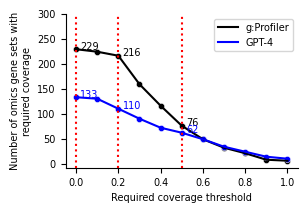

In [38]:
# Plotting the results

plt.figure(figsize=(3,2))
# plot for enrichr coverage thresholding
sns.scatterplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='num_success',s = 20, color='black')
sns.lineplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='num_success', color='black', label='g:Profiler')
# plot for LLM coverage thresholding
sns.scatterplot(data=llm_coverage_thresh_eval_DF, x='coverage_thresh', y='num_success', s = 20, color='blue')
sns.lineplot(data=llm_coverage_thresh_eval_DF, x='coverage_thresh', y='num_success', color='blue', label='GPT-4')

# Setting the y-axis limits make sure all points are visible
plt.ylim(-8, 300)
# Adding vertical lines at specific thresholds
coverage_thresh = [0, 0.2, 0.5]
for thresh in coverage_thresh:
    plt.axvline(x=thresh, color='red', linestyle='dotted')
    # label the line as the percentage/number of omics gene sets that meet the threshold
    enrich_meetsThresh = coverage_thresh_eval_DF.loc[coverage_thresh_eval_DF['coverage_thresh'] == thresh, 'num_success'].values[0]
    plt.text(thresh+0.02, enrich_meetsThresh, f'{int(enrich_meetsThresh)}', color='black', ha='left')
    llm_meetsThresh = llm_coverage_thresh_eval_DF.loc[llm_coverage_thresh_eval_DF['coverage_thresh'] == thresh, 'num_success'].values[0]
    plt.text(thresh+0.02, llm_meetsThresh, f'{int(llm_meetsThresh)}', color='blue', ha='left')

# Adding labels and title
plt.xlabel('Required coverage threshold')
plt.ylabel('Number of omics gene sets with\nrequired coverage')
plt.legend()
sns.despine()
# plt.savefig('figures/omics_revamped_LLM_gprofiler_coverage_thresholding.svg', format='svg', bbox_inches='tight')
# Display the plot
plt.show()

In [47]:
# load the semantic similarity
similarity_df = pd.read_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_simVals_DF.tsv", sep="\t")  
print(similarity_df.shape)
similarity_df.sort_values(by='LLM_name_GO_term_sim', ascending=False)

# select both True and sort by similarity
similarity_df.loc[(similarity_df['LLM_success_TF'] == True) & (similarity_df['gprofiler_success_TF'] == True), :].sort_values(by='LLM_name_GO_term_sim', ascending=False).to_csv("data/omics_revamped_LLM_gprofiler_new_gene_name_DF_APV_only_llmT_enrichT_sort_simVals.tsv", sep="\t", index=False)


(300, 26)
